# Sparkify Project - Complete Dataset

This project is based on data from a hypothetical music streaming service named Sparkify. The data comes in two form: The complete set (12 GB) as well as a tiny subset (128 MB). The project's goal is to use the data to predict churning of the service's users.

This notebook was run on an AWS cluster utilizing the complete dataset.

In [25]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("seaborn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl


  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c0/0c/fc2e007d9a992d997f04a80125b0f183da7fb554f1de701bbb70a8e7d479/pyparsing-2.4.5-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl

  U

In [2]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1  
boto                       2.49.0 
cycler                     0.10.0 
jmespath                   0.9.4  
kiwisolver                 1.1.0  
lxml                       4.4.1  
matplotlib                 3.1.2  
mysqlclient                1.4.4  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.14.5 
pandas                     0.25.3 
pip                        19.3.1 
py-dateutil                2.2    
pyparsing                  2.4.5  
python-dateutil            2.8.1  
python36-sagemaker-pyspark 1.2.6  
pytz                       2019.3 
PyYAML                     3.11   
scipy                      1.4.1  
seaborn                    0.9.0  
setuptools                 42.0.2 
six                        1.12.0 
soupsieve                  1.9.4  
wheel                      0.33.6 
windmill                   1.6

In [26]:
import sys
import time
import datetime
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, sum, count, udf, to_timestamp, min, max, avg, when, length
from pyspark.sql.types import TimestampType, FloatType, BooleanType
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

%matplot plt
sb.set_style("whitegrid")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load and Clean Dataset

In [5]:
# Read in sparkify dataset
# Full dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
# Reduced dataset
mini_event_data = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"

df = spark.read.json(event_data)
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [6]:
df = df.drop("method", "status", "userAgent")
df.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', ts=1538352001000, userId='1749042')

In [7]:
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

In [8]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)

In [9]:
def show_missing_data(df):
    
    """Shows the occurance of nan values in a pyspark dataframe
    
    Input: 
    A pyspark dataframe with a number of features and a column
    labelled 'page' which specifies the type of the entry.
    
    Returns:
    Nothing but plots a figure which shows the structural occurances
    of nan values.
    """
    
    # create initial dataframe with column "page"
    null_vals = df.select("page").distinct()
    # inspect the dataframe column by column and count the number of nans and ""s in each
    for c in df.columns:
        next = df.filter((df[c].isNull() == True) | (df[c] == "")).groupby("page") \
                                                                  .count() \
                                                                  .withColumnRenamed("count", c)
        null_vals = null_vals.join(next, ["page"], "outer")
    df = df.sort("page")

    # copy data into a Pandas DataFrame to facilitate plotting
    p_null_vals = null_vals.toPandas()

    # remove duplicate pages column
    pages = p_null_vals["page"].iloc[:,0].values
    p_null_vals.drop("page", axis=1, inplace=True)
    p_null_vals["page"] = pages
    

    # convert values into a binary format:
    # if null values exist then TRUE else FALSE
    for c in p_null_vals.columns[:-1]:
        p_null_vals[c] = [False if str(x) in ["None", "nan"] else True for x in p_null_vals[c]]

    
    # make a plot which shows the occurances of null values
    plt.figure(figsize=(9, 9))
    yticklabels = [x.title() for x in p_null_vals.columns[:-1]]
    sb.heatmap(p_null_vals.iloc[:, :-1].transpose(), xticklabels=pages, 
               yticklabels=yticklabels, cmap=["white", "red"], cbar=False, 
               square=True, linewidths=0.05, linecolor="grey");
    plt.xlabel("Type of page/transaction", fontsize=11.5);
    plt.ylabel("Dataset feature", fontsize=11.5);
    title = plt.title("The red squares show where in the dataset NULL VALUES occur", 
                      loc="left", fontsize=12.5);
    title.set_position([0, 1.03]);

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

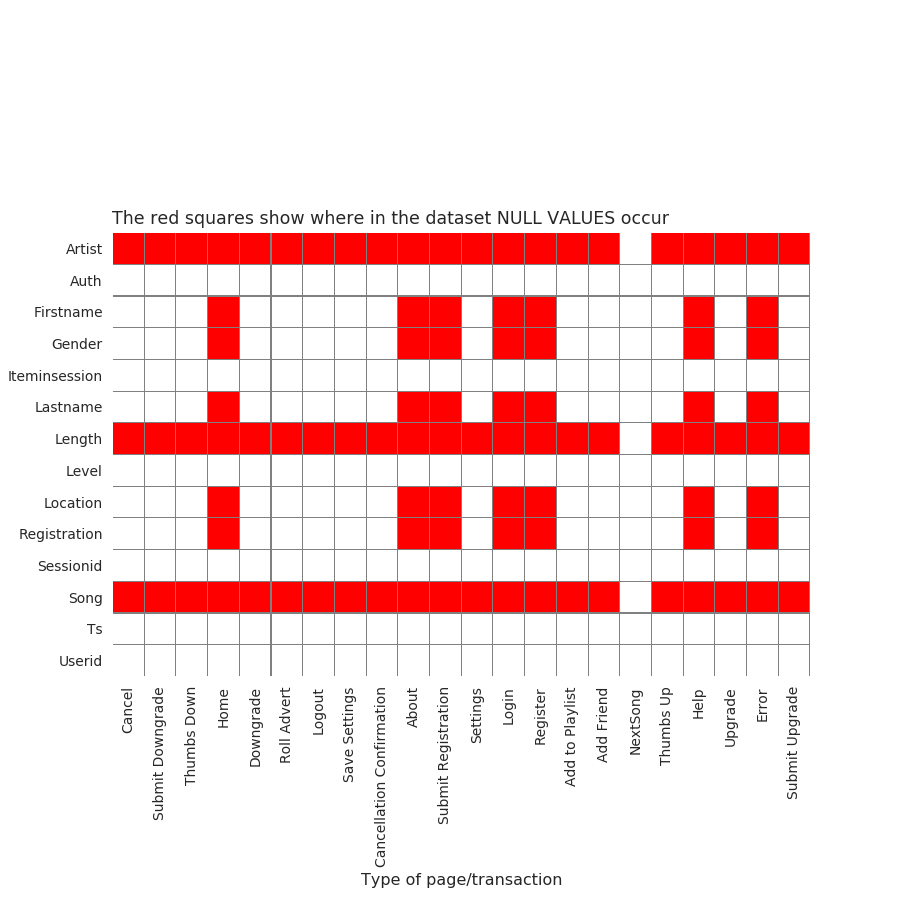

In [10]:
show_missing_data(df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

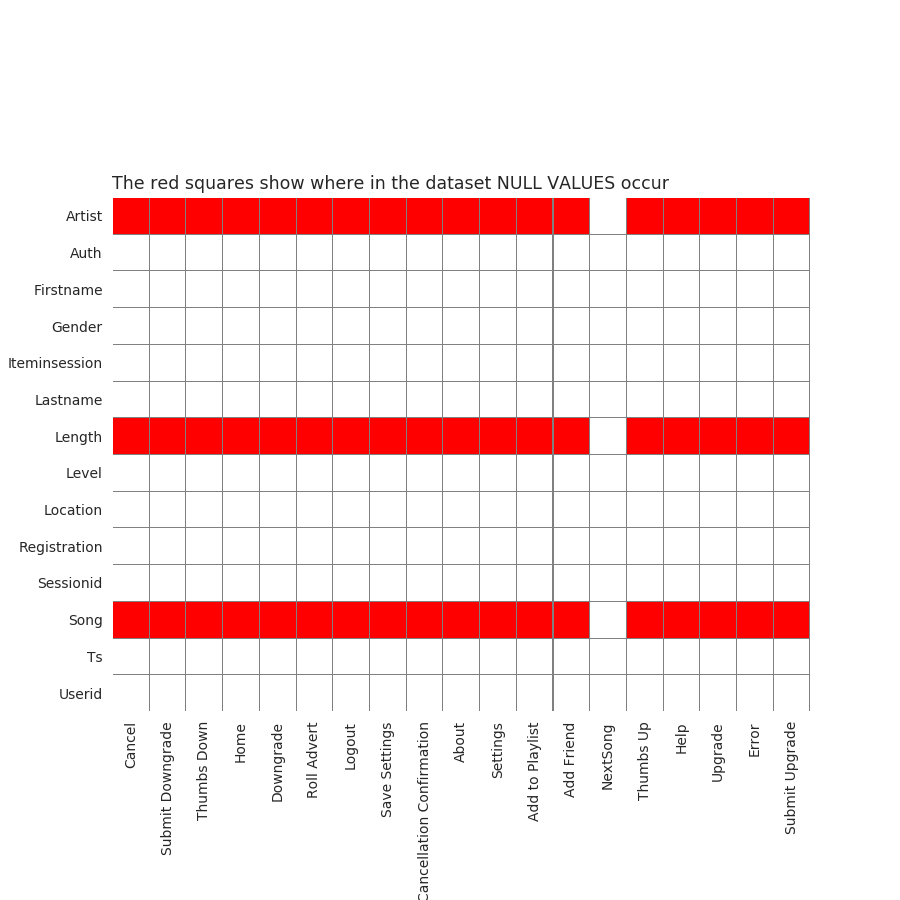

In [11]:
df = df.filter((df.userId != "") & (df.gender != ""))
show_missing_data(df)
%matplot plt

In [12]:
# Combination of columns for which no duplicates should exist
columns = ["userId", "sessionId", "itemInSession"]

if df.count() > df.dropDuplicates(columns).count():
    print("Data has duplicates.")
else:
    print("No duplicates.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

No duplicates.

In [13]:
df = df.withColumn("timestamp", to_timestamp(df.ts / 1e3))
df = df.drop("ts")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Exploratory Data Analysis

### Definion of Churn

The `Cancellation Confirmation` event is used to identify user who churn. 

### Data Exploration

**Question**: Of all users in the dataset how many did cancel the service?

In [14]:
canc_rate = df.filter(df.page == "Cancellation Confirmation").groupby("userId").count().count() / \
            df.groupby("userId").count().count() * 100
print(f"{canc_rate:.1f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22.5%

**Question**: How does the proportion of female users who cancelled the service relate to their overall proportion in the dataset?

In [15]:
overall_fem_prop = df.filter(df.gender == "F").groupby("userId").count().count() \
                   / df.groupby("userId").count().count() * 100
print(f"Overall rate of females in the dataset: {overall_fem_prop:.1f}%")

canc_fem_prop = df.filter((df.gender == "F") & (df.page == "Cancellation Confirmation")) \
                .groupby("userId").count().count() \
                / df.filter(df.page == "Cancellation Confirmation") \
                .groupby("userId").count().count() * 100
print(f"Rate of females among users who cancelled: {canc_fem_prop:.1f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overall rate of females in the dataset: 47.7%
Rate of females among users who cancelled: 46.9%

**Question**: How does the proportion of paying users who cancelled the service relate to the overall proportion of paying users in the dataset?

In [16]:
overall_pay_prop = df.filter(df.level == "paid").groupby("userId").count().count() \
                   / df.groupby("userId").count().count() * 100
print(f"Overall proportion of paying users: {overall_pay_prop:.1f}%")

canc_pay_prop = df.filter((df.level == "paid") & (df.page == "Cancellation Confirmation")) \
                .groupby("userId").count().count() \
                / df.filter(df.page == "Cancellation Confirmation") \
                .groupby("userId").count().count() * 100
print(f"Proportion of paying users among the users who cancelled: {canc_pay_prop:.1f}%")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Overall proportion of paying users: 72.6%
Proportion of paying users among the users who cancelled: 68.4%

**Question**: Which time span is covered by the dataset?

In [17]:
df.agg(min(df.timestamp)).show()
df.agg(max(df.timestamp)).show()
df.agg(max(df.timestamp)).collect()[0][0] - df.agg(min(df.timestamp)).collect()[0][0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|     min(timestamp)|
+-------------------+
|2018-10-01 00:00:01|
+-------------------+

+-------------------+
|     max(timestamp)|
+-------------------+
|2018-12-01 00:00:02|
+-------------------+

datetime.timedelta(61, 1)

# Feature Engineering

**New feature 1**: Number of total interactions (`count_interactions`) of a user.

In [18]:
df_users = df.select("userId", "gender").sort("userId").groupby("userId", "gender").count()
df_users = df_users.withColumnRenamed("count", "count_interactions")
df_users.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+------------------+
| userId|gender|count_interactions|
+-------+------+------------------+
|1000025|     M|              2005|
|1000035|     F|              1577|
|1000083|     M|               596|
|1000103|     F|                95|
|1000164|     F|              1163|
+-------+------+------------------+
only showing top 5 rows

**New feature 2**: User is male (`male`).

In [19]:
is_male = udf(lambda x: True if x == "M" else False, BooleanType())
df_users = df_users.withColumn("male", is_male(df_users.gender)).drop("gender")
df_users.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----+
| userId|count_interactions| male|
+-------+------------------+-----+
|1000025|              2005| true|
|1000035|              1577|false|
|1000083|               596| true|
|1000103|                95|false|
|1000164|              1163|false|
+-------+------------------+-----+
only showing top 5 rows

**New features 3 and 4**: Number of likes (`count_thumbs_up`) and dislikes (`count_thumbs_down`) provided by a user according to the available records.

In [20]:
def count_interactions(interaction_name, new_col_name, df_interactions=df, df_users=df_users):
    """Counts interaction in the interaction dataframe and appends a column 
    with the count to the user dataframe.
    
    Inputs: 
    interaction_name (str): the 'page' category in the interactions dataframe
    new_col_name (str): the label of the column to be added to the user dataframe
    df_interactions (pyspark dataframe): a dataframe containing the interactions 
                                         labelled in the 'page' column for users
                                         labelled in the 'userId' column
    df_users (pyspark dataframe): a dataframe containing the users (column 'userId') 
                                  for whom the interactions are counted
    
    Returns: 
    df_users (pyspark dataframe): the user dataframe with a new column containing the 
                                  interaction counts
    """
    
    interaction_count = df.filter(df.page == interaction_name).groupby("userId").count()
    df_users = df_users.join(interaction_count, "userId", "left")
    df_users = df_users.fillna(0, ["count"])
    df_users = df_users.withColumnRenamed("count", new_col_name)
    
    return df_users

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
start_time = time.time()

# counting thumbs up per user
df_users = count_interactions("Thumbs Up", "count_thumbs_up", df, df_users)
# counting thumbs down per user
df_users = count_interactions("Thumbs Down", "count_thumbs_down", df, df_users)

df_users.show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----+---------------+-----------------+
| userId|count_interactions| male|count_thumbs_up|count_thumbs_down|
+-------+------------------+-----+---------------+-----------------+
|1000280|              1317| true|             53|               33|
|1002185|              2080|false|             92|               14|
|1017805|               320|false|              7|                4|
|1030587|              1752|false|             66|               16|
|1033297|               299| true|             10|                3|
+-------+------------------+-----+---------------+-----------------+
only showing top 5 rows

Operations took 114.1 seconds.

**New features 5 and 6**: Total number of additions to a playlist (`count_playlist`) and total number of friend additions  (`count_friends`) by the user.

In [22]:
start_time = time.time()

# counting thumbs up per user
df_users = count_interactions("Add to Playlist", "count_playlist", df, df_users)
# counting thumbs down per user
df_users = count_interactions("Add Friend", "count_friends", df, df_users)

df_users.show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-----+---------------+-----------------+--------------+-------------+
| userId|count_interactions| male|count_thumbs_up|count_thumbs_down|count_playlist|count_friends|
+-------+------------------+-----+---------------+-----------------+--------------+-------------+
|1000280|              1317| true|             53|               33|            25|           14|
|1002185|              2080|false|             92|               14|            49|           25|
|1017805|               320|false|              7|                4|             5|           13|
|1030587|              1752|false|             66|               16|            46|           23|
|1033297|               299| true|             10|                3|             7|            4|
+-------+------------------+-----+---------------+-----------------+--------------+-------------+
only showing top 5 rows

Operations took 150.8 seconds.

**New features 7 and 8**: Total number of advertisements (`count_ads`) and errors (`count_errors`) the user has seen.

In [23]:
start_time = time.time()

# counting thumbs up per user
df_users = count_interactions("Roll Advert", "count_ads", df, df_users)
# counting thumbs down per user
df_users = count_interactions("Error", "count_errors", df, df_users)

df_users.select("userId", "count_ads", "count_errors").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+------------+
| userId|count_ads|count_errors|
+-------+---------+------------+
|1000280|       74|           3|
|1002185|        1|           2|
|1017805|        6|           0|
|1030587|        0|           1|
|1033297|       10|           0|
+-------+---------+------------+
only showing top 5 rows

Operations took 197.1 seconds.

**New feature 9**: Time since the last interaction (`duration_inactivity_hrs`) in hours -excluding cancellation- by the user.

In [24]:
start_time = time.time()

# Determine the time of the last user interaction -excluding cancellation- 
# and append it to the user dataframe
df_temp = df.filter(~df.page.isin(["Cancel", "Cancellation Confirmation"])) \
            .select("userId", 
                    "timestamp", 
                    max("timestamp").over(Window.partitionBy("userId")).alias("time_last_action"))
df_temp = df_temp.groupby("userId").agg(max(df_temp.time_last_action).alias("time_last_action"))
df_users = df_users.join(df_temp, "userId", "left")

# Determine the time of the last entry in the df and calculate 
# the time elapsed since the last action of the user as determined above
last_timestamp = df.agg(max(df.timestamp)).collect()[0][0]
duration = udf(lambda x: round((last_timestamp - x).total_seconds() / 3600, 2), FloatType())
df_users = df_users.withColumn("duration_inactivity_hrs", duration(df_users.time_last_action))
df_users = df_users.drop("time_last_action")
df_users.select("userId", "duration_inactivity_hrs").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------------+
| userId|duration_inactivity_hrs|
+-------+-----------------------+
|1000280|                 409.02|
|1002185|                  49.86|
|1017805|                 834.51|
|1030587|                  24.17|
|1033297|                  92.14|
+-------+-----------------------+
only showing top 5 rows

Operations took 241.6 seconds.

**New feature 10**: Number of songs (`count_songs_7d`) listened to by a user in the last 7 days.

In [25]:
start_time = time.time()

# Determine the point in time 7 days before the last dataset entry
seven_days_ago = last_timestamp - datetime.timedelta(days=7)

df_temp = df.filter((df.timestamp >= seven_days_ago) & (df.page == "NextSong")).groupby("userId").count()
df_users = df_users.join(df_temp, "userId", "left")
df_users = df_users.fillna(0, ["count"])
df_users = df_users.withColumnRenamed("count", "count_songs_7d")
df_users.select("userId", "count_interactions", "count_songs_7d").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+--------------+
| userId|count_interactions|count_songs_7d|
+-------+------------------+--------------+
|1000280|              1317|             0|
|1002185|              2080|           294|
|1017805|               320|             0|
|1030587|              1752|           300|
|1033297|               299|           158|
+-------+------------------+--------------+
only showing top 5 rows

Operations took 239.7 seconds.

**New feature 11**: Average time (in minutes) a user listened to a song (`avg_time_song_min`).

In [26]:
start_time = time.time()

# Calculate for every user the average duration (in minutes) per song he/she played
# and append this information to the user dataframe
df_temp = df.filter(df.page == "NextSong").groupby("userId").agg((avg("length")/60).alias("avg_time_song_min"))
df_temp = df_temp.groupby("userId").agg(max(df_temp.avg_time_song_min).alias("avg_time_song_min"))
df_users = df_users.join(df_temp, "userId", "left")
df_users.select("userId", "avg_time_song_min").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
| userId|avg_time_song_min|
+-------+-----------------+
|1000280|4.229450379321593|
|1002185| 4.15398951856018|
|1017805|4.218067877333333|
|1030587|4.124624801517211|
|1033297|4.168063471751411|
+-------+-----------------+
only showing top 5 rows

Operations took 272.5 seconds.

**New features 12 and 13**: User has upgraded (`upgrade`) and or downgraded (`downgrade`) the service.

In [27]:
start_time = time.time()

df_users = count_interactions("Submit Upgrade", "upgrade", df, df_users)
df_users = count_interactions("Submit Downgrade", "downgrade", df, df_users)
df_users = df_users.withColumn("upgrade", when(df_users.upgrade != 0, True).otherwise(False))
df_users = df_users.withColumn("downgrade", when(df_users.upgrade != 0, True).otherwise(False))
df_users.select("userId", "upgrade", "downgrade").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------+---------+
| userId|upgrade|downgrade|
+-------+-------+---------+
|1000280|   true|     true|
|1002185|  false|    false|
|1017805|  false|    false|
|1030587|   true|     true|
|1033297|   true|     true|
+-------+-------+---------+
only showing top 5 rows

Operations took 306.4 seconds.

**New feature 14**: User currently paying for the service (`paying`).

In [28]:
start_time = time.time()

w = Window.partitionBy("userId")
df_temp = df.withColumn("maxTimestamp", max("timestamp").over(w)) \
            .where(col("timestamp") == col("maxTimestamp")) \
            .select("userId", "level") \
            .dropDuplicates()
df_users = df_users.join(df_temp, "userId", "left")
df_users = df_users.withColumn("paying", when(df_users.level == "paid", True).otherwise(False)).drop("level")
df_users.select("userId", "paying").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+
| userId|paying|
+-------+------+
|1000280| false|
|1002185|  true|
|1017805|  true|
|1030587|  true|
|1033297|  true|
+-------+------+
only showing top 5 rows

Operations took 333.6 seconds.

**New feature 15**: User has cancelled the service (`cancelled`).

In [29]:
start_time = time.time()

df_users = count_interactions("Cancellation Confirmation", "cancelled", df, df_users)
df_users = df_users.withColumn("cancelled", when(df_users.cancelled != 0, True).otherwise(False))
df_users.select("userId", "cancelled").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+
| userId|cancelled|
+-------+---------+
|1000280|     true|
|1002185|    false|
|1017805|    false|
|1030587|    false|
|1033297|    false|
+-------+---------+
only showing top 5 rows

Operations took 362.8 seconds.

In [30]:
df_users.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- count_interactions: long (nullable = false)
 |-- male: boolean (nullable = true)
 |-- count_thumbs_up: long (nullable = true)
 |-- count_thumbs_down: long (nullable = true)
 |-- count_playlist: long (nullable = true)
 |-- count_friends: long (nullable = true)
 |-- count_ads: long (nullable = true)
 |-- count_errors: long (nullable = true)
 |-- duration_inactivity_hrs: float (nullable = true)
 |-- count_songs_7d: long (nullable = true)
 |-- avg_time_song_min: double (nullable = true)
 |-- upgrade: boolean (nullable = false)
 |-- downgrade: boolean (nullable = false)
 |-- paying: boolean (nullable = false)
 |-- cancelled: boolean (nullable = false)

In [31]:
df_users.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22279

In [32]:
# write user df
output_path = 's3://christianfolder123/df_users'
df_users.write.mode('overwrite').save(output_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Modeling
The full dataset is to be split into a train, test, and validation set. Three alternative machine learning methods will be implemented before selecting the most useful model. The model optimization and the model selection will be based on the F1 score.

In [28]:
input_path = 's3://christianfolder123/df_users'
df_users = spark.read.load(input_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# convert independent features into vector
ignore = ["userId", "cancelled"]
inputCols = [c for c in df_users.columns if c not in ignore]
vec_assembler = VectorAssembler(inputCols=inputCols, outputCol="user_features", handleInvalid="skip")
df_users = vec_assembler.transform(df_users)

# normalize features vector
scaler = Normalizer(inputCol="user_features", outputCol="user_features_norm")
df_users = scaler.transform(df_users)

df_users.select("userId", "user_features_norm").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
| userId|  user_features_norm|
+-------+--------------------+
|1002324|(14,[0,2,4,5,6,8,...|
|1007782|[0.98510629578554...|
|1015997|[0.99015156563723...|
|1028247|(14,[0,2,3,5,6,8,...|
|1028481|[0.78752353701278...|
+-------+--------------------+
only showing top 5 rows

In [30]:
df_users.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22263

In [31]:
data = df_users.select(col("user_features_norm").alias("features"),
                       col("cancelled").alias("label"))
# convert label into numeric
data = data.withColumn("label", col("label").cast("integer"))
data.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22263

In [32]:
train, temp = data.randomSplit([0.6, 0.4], seed=42)
test, validate = temp.randomSplit([0.5, 0.5], seed=42)
train.count(), test.count(), validate.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(13299, 4429, 4535)

In [33]:
def evaluation(preds):
    """Prints aggregated prediction results and calculates evaluation metrics. 
    
    Input 
    preds: PySpark ml prediction dataframe
    
    Returns Nothing
    """
    
    preds.groupBy('label','prediction').count().show()

    accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(preds)
    recall_label0 = preds.filter((preds.label == 0) & (preds.prediction == 0)).count() / \
                    preds.filter(preds.label == 0).count()
    recall_label1 = preds.filter((preds.label == 1) & (preds.prediction == 1)).count() / \
                    preds.filter(preds.label == 1).count()
    f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(preds)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: [{recall_label0:.2f}, " \
                     f"{recall_label1:.2f}]")
    print(f"F1 score: {f1:.2f}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Model 1: Logistic regressor

In [34]:
start_time = time.time()

lr = LogisticRegression(maxIter=10)
param_grid = ParamGridBuilder() \
             .addGrid(lr.regParam, [0, 0.05, 0.1]) \
             .addGrid(lr.elasticNetParam, [0.1, 0.2, 0.5, 1]) \
             .addGrid(lr.fitIntercept, [True, False]) \
             .build()
lr_cross_val = CrossValidator(estimator=lr,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=3,
                              seed=42)
lr_cv_model = lr_cross_val.fit(train)
lr_best_model = lr_cv_model.bestModel

lr_best_model.summary.predictions.show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,6,...|  0.0|[1.39426593010389...|[0.80127240138882...|       0.0|
|(14,[0,1,2,3,4,6,...|  0.0|[2.54962019249241...|[0.92754799468823...|       0.0|
|(14,[0,1,2,3,4,6,...|  0.0|[4.48342273798946...|[0.98883145704838...|       0.0|
|(14,[0,1,2,3,4,8,...|  1.0|[-0.2079098301463...|[0.44820897026250...|       1.0|
|(14,[0,1,2,3,4,8,...|  0.0|[1.56389845512010...|[0.82691204439180...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

Operations took 155.0 seconds.

In [35]:
print("Logistic Regression - TRAINING Evaluation")
lr_best_model.summary.predictions.groupBy('label','prediction').count().show()
print(f"Accuracy: {lr_best_model.summary.accuracy:.2f}")
print(f"Recall: [{lr_best_model.summary.recallByLabel[0]:.2f}, " \
                 f"{lr_best_model.summary.recallByLabel[1]:.2f}]")
f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(lr_best_model.summary.predictions)
print(f"F1 score: {f1:.2f}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-34:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1499



Logistic Regression - TRAINING Evaluation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 2053|
|  0.0|       1.0|  724|
|  1.0|       0.0|  927|
|  0.0|       0.0| 9595|
+-----+----------+-----+

Accuracy: 0.88
Recall: [0.93, 0.69]
F1 score: 0.87

In [36]:
lr_best_model.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='LogisticRegression_c48011db1703', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_c48011db1703', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.1, Param(parent='LogisticRegression_c48011db1703', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_c48011db1703', name='featuresCol', doc='features column name'): 'features', Param(parent='LogisticRegression_c48011db1703', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_c48011db1703', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticRegression_c48011db1703', name='maxIter', doc='maximum number of iterations (>= 0)'): 10, Pa

In [37]:
lr_test_preds = lr_best_model.transform(test)
lr_test_preds.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,8,...|    0|[1.28543611889496...|[0.78337370322590...|       0.0|
|(14,[0,1,2,3,6,8,...|    1|[-0.4405978892144...|[0.39159851344704...|       1.0|
|(14,[0,1,2,3,6,8,...|    0|[0.35724852513486...|[0.58837421678443...|       0.0|
|(14,[0,1,2,4,5,6,...|    0|[1.28804783201217...|[0.78381658120777...|       0.0|
|(14,[0,1,2,4,5,6,...|    0|[3.44564556023446...|[0.96910101627558...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

In [38]:
print("Logistic Regression - TEST Evalutation")
evaluation(lr_test_preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression - TEST Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  294|
|    0|       0.0| 3196|
|    1|       1.0|  704|
|    0|       1.0|  235|
+-----+----------+-----+

Accuracy: 0.88
Recall: [0.93, 0.71]
F1 score: 0.88

### Model 2: Naive Bayes classifier

In [39]:
start_time = time.time()

nb = NaiveBayes()

param_grid = ParamGridBuilder() \
             .addGrid(nb.smoothing, [0, 0.1, 0.3, 0.5]) \
             .addGrid(nb.thresholds, [[0.75, 0.25], [0.7, 0.3], [0.65, 0.35]]) \
             .build()
nb_cross_val = CrossValidator(estimator=nb,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=5,
                              seed=42)
nb_cv_model = nb_cross_val.fit(train)
nb_best_model = nb_cv_model.bestModel

nb_train_preds = nb_best_model.transform(train)
nb_train_preds.show(10)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,6,...|    0|[-2.1119635061177...|[0.65681628369297...|       1.0|
|(14,[0,1,2,3,4,6,...|    0|[-2.1616755336117...|[0.67743767990024...|       1.0|
|(14,[0,1,2,3,4,6,...|    0|[-2.1293385684032...|[0.71219246293730...|       0.0|
|(14,[0,1,2,3,4,8,...|    1|[-1.8437242043182...|[0.61910927424871...|       1.0|
|(14,[0,1,2,3,4,8,...|    0|[-1.9238789898309...|[0.62271697502637...|       1.0|
|(14,[0,1,2,3,4,8,...|    0|[-2.0679790838076...|[0.64066217495154...|       1.0|
|(14,[0,1,2,3,5,6,...|    0|[-1.9004599875145...|[0.62785081615470...|       1.0|
|(14,[0,1,2,3,5,8,...|    0|[-1.8171387563251...|[0.61598719619860...|       1.0|
|(14,[0,1,2,3,6,8,...|    0|[-3.0674283485924...|[0.80661387311200...|       0.0|
|(14,[0,1,2,3,6,

In [40]:
nb_best_model.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='NaiveBayes_280154c7728b', name='featuresCol', doc='features column name'): 'features', Param(parent='NaiveBayes_280154c7728b', name='labelCol', doc='label column name'): 'label', Param(parent='NaiveBayes_280154c7728b', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli.'): 'multinomial', Param(parent='NaiveBayes_280154c7728b', name='predictionCol', doc='prediction column name'): 'prediction', Param(parent='NaiveBayes_280154c7728b', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability', Param(parent='NaiveBayes_280154c7728b', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction', Param(parent='NaiveBayes_280154c7728b', name='smoothing', doc='The smoothing param

In [41]:
print("Naive Bayes - TRAINING Evalutation")
evaluation(nb_train_preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Naive Bayes - TRAINING Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1590|
|    0|       0.0| 8599|
|    1|       1.0| 1390|
|    0|       1.0| 1720|
+-----+----------+-----+

Accuracy: 0.75
Recall: [0.83, 0.47]
F1 score: 0.75

In [42]:
nb_test_preds = nb_best_model.transform(test)
nb_test_preds.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,8,...|    0|[-1.9589444951047...|[0.62920549460105...|       1.0|
|(14,[0,1,2,3,6,8,...|    1|[-1.8081660656103...|[0.61572900554718...|       1.0|
|(14,[0,1,2,3,6,8,...|    0|[-1.8409405863930...|[0.61761714124633...|       1.0|
|(14,[0,1,2,4,5,6,...|    0|[-1.9510724025705...|[0.62794044548848...|       1.0|
|(14,[0,1,2,4,5,6,...|    0|[-2.1107013641575...|[0.65321385622604...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

In [43]:
print("Naive Bayes - TEST Evalutation")
evaluation(nb_test_preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Naive Bayes - TEST Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  538|
|    0|       0.0| 2861|
|    1|       1.0|  460|
|    0|       1.0|  570|
+-----+----------+-----+

Accuracy: 0.75
Recall: [0.83, 0.46]
F1 score: 0.75

### Model 3: Random forest classifier

In [44]:
start_time = time.time()

rfc = RandomForestClassifier()

param_grid = ParamGridBuilder() \
             .addGrid(rfc.maxDepth, [5, 10, 15]) \
             .addGrid(rfc.numTrees, [10, 20, 30]) \
             .build()
rfc_cross_val = CrossValidator(estimator=rfc,
                               estimatorParamMaps=param_grid,
                               evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                               numFolds=5,
                               seed=42)
rfc_cv_model = rfc_cross_val.fit(train)
rfc_best_model = rfc_cv_model.bestModel

rfc_train_preds = rfc_best_model.transform(train)
rfc_train_preds.show(10)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,6,...|    0|[27.0161154033843...|[0.90053718011281...|       0.0|
|(14,[0,1,2,3,4,6,...|    0|[28.6934268315906...|[0.95644756105302...|       0.0|
|(14,[0,1,2,3,4,6,...|    0|[28.8278295660629...|[0.96092765220209...|       0.0|
|(14,[0,1,2,3,4,8,...|    1|[4.74177900552809...|[0.15805930018426...|       1.0|
|(14,[0,1,2,3,4,8,...|    0|[27.8938824944043...|[0.92979608314681...|       0.0|
|(14,[0,1,2,3,4,8,...|    0|[29.025003899678,...|[0.96750012998926...|       0.0|
|(14,[0,1,2,3,5,6,...|    0|[27.9163476189272...|[0.93054492063090...|       0.0|
|(14,[0,1,2,3,5,8,...|    0|[21.8967021761245...|[0.72989007253748...|       0.0|
|(14,[0,1,2,3,6,8,...|    0|[29.4259337394661...|[0.98086445798220...|       0.0|
|(14,[0,1,2,3,6,

In [45]:
print("Random Forest - TRAINING Evalutation")
evaluation(rfc_train_preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest - TRAINING Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  590|
|    0|       0.0|10081|
|    1|       1.0| 2390|
|    0|       1.0|  238|
+-----+----------+-----+

Accuracy: 0.94
Recall: [0.98, 0.80]
F1 score: 0.94

In [46]:
rfc_best_model.extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='RandomForestClassifier_7e18eef9ec8a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False, Param(parent='RandomForestClassifier_7e18eef9ec8a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10, Param(parent='RandomForestClassifier_7e18eef9ec8a', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto', Param(parent='RandomForestClassifier_7e18eef9ec8a', name='featuresCol', doc='features column name'): 'features', Param(parent='RandomForestClassifier_7e18eef9ec8a', name

In [47]:
rfc_test_preds = rfc_best_model.transform(test)
rfc_test_preds.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,8,...|    0|[28.0125805142093...|[0.93375268380697...|       0.0|
|(14,[0,1,2,3,6,8,...|    1|[7.17608413410283...|[0.23920280447009...|       1.0|
|(14,[0,1,2,3,6,8,...|    0|[27.5071403365890...|[0.91690467788630...|       0.0|
|(14,[0,1,2,4,5,6,...|    0|[28.6828456305810...|[0.95609485435270...|       0.0|
|(14,[0,1,2,4,5,6,...|    0|[29.4368926467483...|[0.98122975489161...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

In [48]:
print("Random Forest - TEST Evalutation")
evaluation(rfc_test_preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest - TEST Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  245|
|    0|       0.0| 3304|
|    1|       1.0|  753|
|    0|       1.0|  127|
+-----+----------+-----+

Accuracy: 0.92
Recall: [0.96, 0.75]
F1 score: 0.91

### Model selection and validation

**Best model** of the models tested: **Random forest model** with 30 trees to train and a maximum depth of 10. The model's f1 score on the test set was 0.91, which was significantly higher than that of the Naive Bayes model (0.75) and slightly higher than the Logistic regression model (0.88). 

**Next step**: Valdidate the result.

In [49]:
rfc_validation_preds = rfc_best_model.transform(validate)
rfc_validation_preds.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,6,...|    0|[28.1836873745067...|[0.93945624581689...|       0.0|
|(14,[0,1,2,3,4,6,...|    0|[28.0314965604109...|[0.93438321868036...|       0.0|
|(14,[0,1,2,3,4,6,...|    0|[18.9708268293384...|[0.63236089431128...|       0.0|
|(14,[0,1,2,3,4,6,...|    0|[27.0863325776140...|[0.90287775258713...|       0.0|
|(14,[0,1,2,3,6,8,...|    0|[27.8706846449030...|[0.92902282149676...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

In [50]:
print("Logistic Regression - VALIDATION")
evaluation(rfc_validation_preds)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression - VALIDATION
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  254|
|    0|       0.0| 3369|
|    1|       1.0|  770|
|    0|       1.0|  142|
+-----+----------+-----+

Accuracy: 0.91
Recall: [0.96, 0.75]
F1 score: 0.91

**Successfully validated!**